In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import time
import pprint
import itertools
import pickle
import sklearn
import dask
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import dask
import dask.dataframe as dd
import dask.array as da
# Percentiles
from scipy.stats import percentileofscore
from IPython.display import display

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Proportion of Direct Citations by Similarity Bin

In [2]:
mdc = fastparquet.ParquetFile("DataStore/2018-07-P2/mutual_cited_0716.parq").to_pandas()
print(len(mdc))
# Add match
for c in ["inv_msa", "naics_name", "primclass"]:
    mdc["{0}_match".format(c)] = (mdc["tp_{0}".format(c)] == mdc["op_{0}".format(c)])
    
# Add bins
import math

def sim_bin(x, a):
    try:
        return round(round(x / a) * a, -int(math.floor(math.log10(a))))
    except:
        return np.nan
    
mdc["bin_sim_ldavecs"] = mdc["sim_ldavecs"].apply(lambda x: sim_bin(x, 0.1))
mdc["bin_sim_docvecs"] = mdc["sim_docvecs"].apply(lambda x: sim_bin(x, 0.1))
   
# # Round nearest
import math
def round_nearest(x, a):
    try:
        g = round(round(x / a) * a, -int(math.floor(math.log10(a))))
    except Exception:
        g = np.nan
    return g

# Percentiles
for c in ["sim_ldavecs", "sim_docvecs"]:
    mdc["perc_{0}".format(c)] = sp.stats.rankdata(mdc[c], "average")/len(mdc[c])
    # Round to closest 10th percentile
    mdc["perc_bin_{0}".format(c)] = mdc["perc_{0}".format(c)].apply(lambda x: round_nearest(x, 0.1))

2445169


In [3]:
mdc["bin_sim_docvecs"]

index
0          0.1
1          0.4
2          0.3
3          0.3
4          0.3
5          0.2
6          0.4
7          0.2
8          0.3
9          0.1
10         0.0
11         0.1
12         0.1
13         0.2
14         0.2
15         0.2
16         0.0
17         0.2
18         0.2
19         0.2
20         0.3
21         0.3
22         0.4
23         0.2
24         0.3
25         0.3
26         0.2
27         0.4
28         0.4
29         0.4
          ... 
2445139    0.5
2445140    0.2
2445141    0.4
2445142    0.4
2445143    0.1
2445144    0.2
2445145    0.7
2445146    0.8
2445147    0.2
2445148    0.4
2445149    0.2
2445150    0.2
2445151    0.4
2445152    0.5
2445153    0.2
2445154    0.6
2445155    0.4
2445156    0.2
2445157    0.1
2445158    0.3
2445159    0.1
2445160    0.4
2445161    0.3
2445162    0.1
2445163    0.3
2445164    0.8
2445165    0.1
2445166    0.3
2445167    0.3
2445168    0.3
Name: bin_sim_docvecs, Length: 2445169, dtype: float64

In [4]:
np.round(mdc["sim_docvecs"].describe(),2)

count    2445169.00
mean           0.22
std            0.15
min           -0.65
25%            0.13
50%            0.22
75%            0.31
max            0.94
Name: sim_docvecs, dtype: float64

In [5]:
print(np.percentile(mdc["sim_docvecs"], 1), np.percentile(mdc["sim_docvecs"], 99))

-0.08718255621522242 0.6170891018947644


In [6]:
# Pub bins with frequency less than 1000 with other bins
mdc.loc[mdc["bin_sim_docvecs"] <= -0.1, "bin_sim_docvecs"] = -0.1
mdc.loc[mdc["bin_sim_docvecs"] >= 0.7, "bin_sim_docvecs"] = 0.7

In [7]:
# Note: bin_sim_docvecs quite bunched. So will have to get rid of very low and very high values
mdc = mdc.loc[(mdc["bin_sim_docvecs"] >= - 0.2) & (mdc["bin_sim_docvecs"] <= 0.8)]
print(len(mdc))

2445169


___
### 2. Plots

In [10]:
%matplotlib inline
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P2/ResultsGraphs/SNC/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g

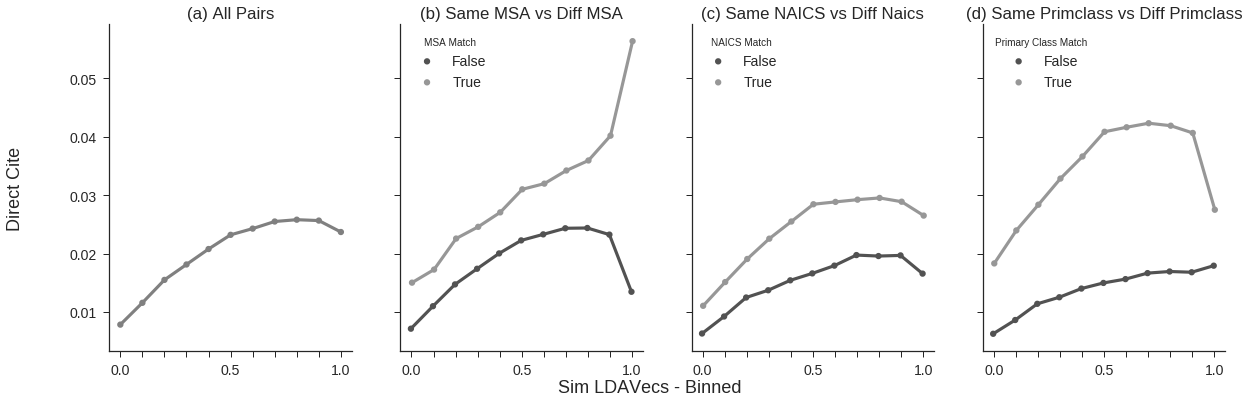

In [6]:
%matplotlib inline
f, axarr = plt.subplots(1, 4, sharex = False, sharey = True, figsize=(20,6))

x1 = "bin_sim_ldavecs"
order1 = None
conf_int1 = None
y1 = "op_cites_tp"

# Overall - No MSA Match Hue
df = mdc
g3 = p2(x = x1, y = y1, order = order1, data = df, ax = axarr[0], conf_int = conf_int1)
g3.set_title("(a) All Pairs")

# Overall - MSA Match Hue
hue1 = "inv_msa_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[1])
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("(b) Same MSA vs Diff MSA")


# NAICS Match
hue1 = "naics_name_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[2])
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("(c) Same NAICS vs Diff Naics")


# Primclass Match
hue1 = "primclass_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[3])
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("(d) Same Primclass vs Diff Primclass")


for ax in axarr.flatten():
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_xticklabels()[::5], visible=True)
#     ax.set_xticks([])
    
# Set common labels
font2 = matplotlib.font_manager.FontProperties(size=12)
f.text(0.5, 0.04, c_dict[x1], ha='center', va='center', fontproperties=font2).set_fontsize(18)
f.text(0.06, 0.5, c_dict[y1], ha='center', va='center', rotation='vertical', fontproperties=font2).set_fontsize(18)

plt.savefig(savepath+"3b-LDA-DC.png")

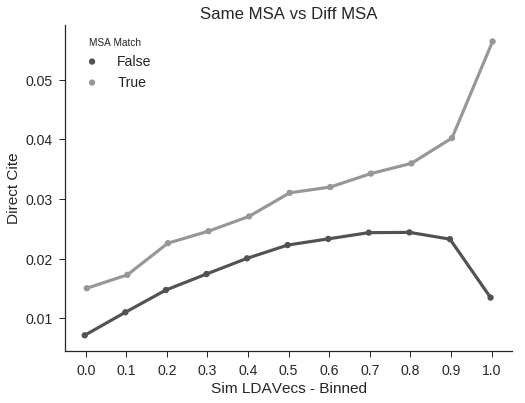

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,6))

x1 = "bin_sim_ldavecs"
order1 = None
conf_int1 = None
y1 = "op_cites_tp"

# Overall - No MSA Match Hue
df = mdc
hue1 = "inv_msa_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("Same MSA vs Diff MSA")
g3.set_ylabel(c_dict[y1])
g3.set_xlabel(c_dict[x1])

plt.savefig(savepath+"3b-LDA-MSA-DC.png")
plt.show()

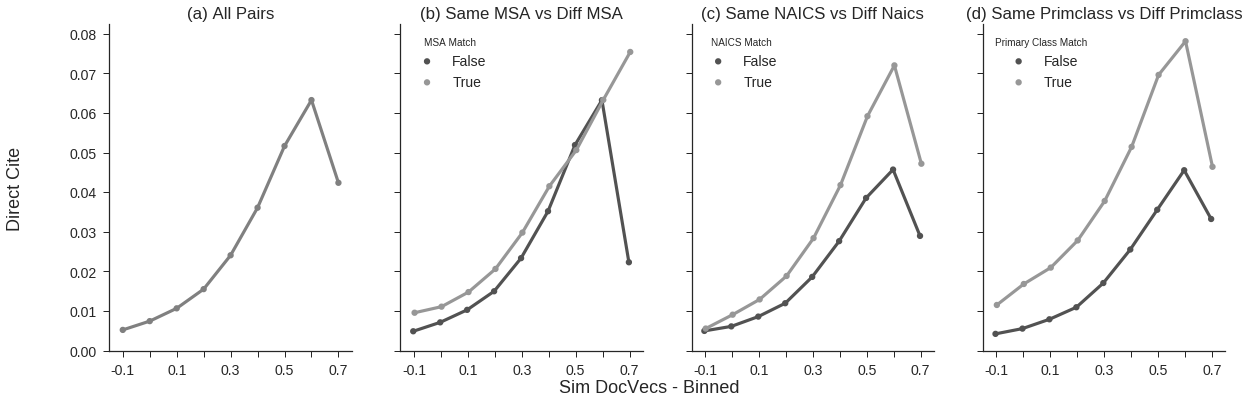

In [30]:
%matplotlib inline
f, axarr = plt.subplots(1, 4, sharex = False, sharey = True, figsize=(20,6))

x1 = "bin_sim_docvecs"
order1 = None
conf_int1 = None
y1 = "op_cites_tp"

# Overall - No MSA Match Hue
df = mdc
g3 = p2(x = x1, y = y1, order = order1, data = df, ax = axarr[0], conf_int = conf_int1)
g3.set_title("(a) All Pairs")

# Overall - MSA Match Hue
hue1 = "inv_msa_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[1])
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("(b) Same MSA vs Diff MSA")


# NAICS Match
hue1 = "naics_name_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[2])
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("(c) Same NAICS vs Diff Naics")


# Primclass Match
hue1 = "primclass_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = axarr[3])
g3.legend(loc='upper left', title = c_dict[hue1])
g3.set_title("(d) Same Primclass vs Diff Primclass")


for ax in axarr.flatten():
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_xticklabels()[::2], visible=True)
#     ax.set_xticks([])
    
# Set common labels
font2 = matplotlib.font_manager.FontProperties(size=12)
f.text(0.5, 0.04, c_dict[x1], ha='center', va='center', fontproperties=font2).set_fontsize(18)
f.text(0.06, 0.5, c_dict[y1], ha='center', va='center', rotation='vertical', fontproperties=font2).set_fontsize(18)

plt.savefig(savepath+"3b-DV-DC.png")

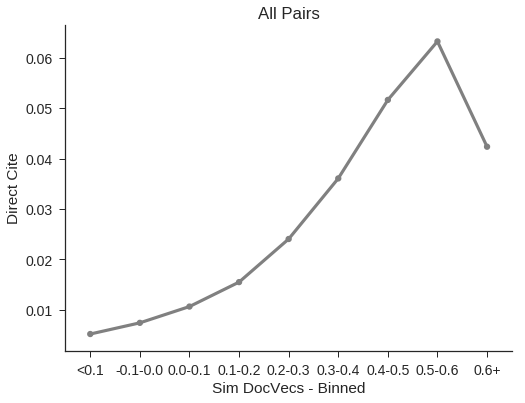

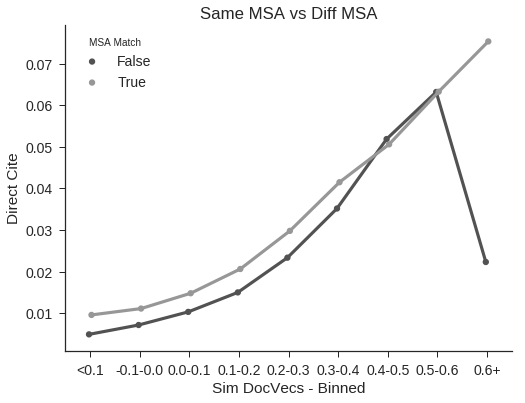

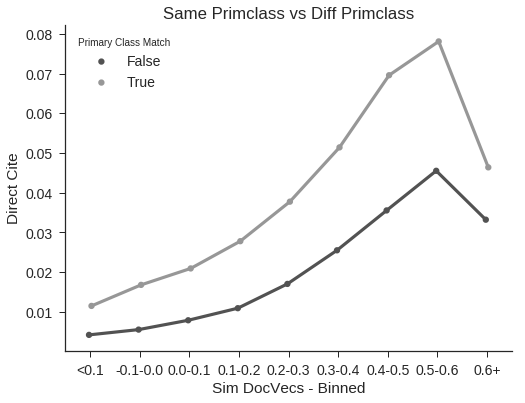

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,6))

x1 = "bin_sim_docvecs"
order1 = None
conf_int1 = None
y1 = "op_cites_tp"
x_labels = ["<0.1", "-0.1-0.0", "0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6+"]
# Overall - No MSA Match Hue
df = mdc

g3 = p2(x = x1, y = y1, order = order1, data = df, ax = ax, conf_int = conf_int1)
g3.set_title("All Pairs")
ax.set_xticklabels(x_labels)
g3.set_ylabel(c_dict[y1])
g3.set_xlabel(c_dict[x1])
plt.savefig(savepath+"3b-DV-All-DC.png")
plt.show()
del(fig,ax)

fig, ax = plt.subplots(figsize=(8,6))
hue1 = "inv_msa_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
ax.set_xticklabels(x_labels)
g3.set_title("Same MSA vs Diff MSA")
g3.set_ylabel(c_dict[y1])
g3.set_xlabel(c_dict[x1])

# plt.setp(ax.get_xticklabels(), visible=False)
# plt.setp(ax.get_xticklabels(), visible=True)

plt.savefig(savepath+"3b-DV-MSA-DC.png")
plt.show()
del(fig,ax)

fig, ax = plt.subplots(figsize=(8,6))
hue1 = "primclass_match"
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
ax.set_xticklabels(x_labels)
g3.set_ylabel(c_dict[y1])
g3.set_xlabel(c_dict[x1])
g3.set_title("Same Primclass vs Diff Primclass")

plt.savefig(savepath+"3b-DV-PC-DC.png")
plt.show()
del(fig,ax)

____
### 3. Tables

In [20]:
i_dict = {'all_count': "All Pairs, $N$", 
          'all_direct_cites': "All Pairs, Prop Cited", 
          'inv_msa_match_True_count': "Same MSA, $N$",
       'inv_msa_match_True_direct_cites': "Same MSA, Prop Cited",
          'inv_msa_match_False_count': "Diff MSA, $N$",
       'inv_msa_match_False_direct_cites': "Diff MSA, Prop Cited",
          'naics_name_match_True_count': "Same NAICS, $N$",
       'naics_name_match_True_direct_cites': "Same NAICS, Prop Cited",
          'naics_name_match_False_count': "Diff NAICS, $N$",
       'naics_name_match_False_direct_cites': "Diff NAICS, Prop Cited",
          'primclass_match_True_count': "Same Primclass, $N$" ,
       'primclass_match_True_direct_cites': "Same Primclass, Prop Cited",
          'primclass_match_False_count': "Diff Primclass, $N$",
       'primclass_match_False_direct_cites': "Diff Primclass, Prop Cited"}

In [26]:
# No p-value
tab = {}
x_labels = {
    "bin_sim_ldavecs": ["0.0", "0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7",
                       "0.7-0.8", "0.8-0.9", "0.9-1.0"],
    "bin_sim_docvecs": ["<0.1", "-0.1-0.0", "0.0-0.1", "0.1-0.2", "0.2-0.3",\
                        "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6+"]
}
for dm in ["bin_sim_ldavecs", "bin_sim_docvecs"]:
    summ = pd.DataFrame()
    for c in ["all", "inv_msa_match", "naics_name_match", "primclass_match"]:
        
        if c == "all":
            summ["all_count"] = mdc.groupby(dm).size().astype(str)
            summ["all_direct_cites"] = np.round(mdc[[dm, "op_cites_tp"]].groupby(dm).mean(),3)
        else:
            c_vals = [True, False]
            for m in c_vals:
                m2 = mdc.loc[mdc[c] == m]
                summ["{0}_{1}_count".format(c, str(m))] = m2.groupby([dm]).size().astype(str)
                summ["{0}_{1}_direct_cites".format(c, str(m))] = np.round(m2[[dm, "op_cites_tp"]].groupby(dm).mean(),3)
    summ = summ.rename(columns=i_dict)
    summ = summ.T
    summ.columns = x_labels[dm]
    tab[dm] = summ
tab_no_p = tab

In [27]:
for k,v in tab_no_p.items():
    print(k)
    display(v)
    print(v.to_latex())

bin_sim_ldavecs


,0.0,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
"All Pairs, $N$",123934,235087,267792,291672,304847,303271,290423,263111,214414,125698,24920
"All Pairs, Prop Cited",0.008,0.012,0.016,0.018,0.021,0.023,0.024,0.026,0.026,0.026,0.024
"Same MSA, $N$",10964,21691,26330,29833,32459,33005,32944,30779,26368,17835,5942
"Same MSA, Prop Cited",0.015,0.017,0.023,0.025,0.027,0.031,0.032,0.034,0.036,0.04,0.056
"Diff MSA, $N$",112970,213396,241462,261839,272388,270266,257479,232332,188046,107863,18978
"Diff MSA, Prop Cited",0.007,0.011,0.015,0.017,0.02,0.022,0.023,0.024,0.024,0.023,0.013
"Same NAICS, $N$",39778,93385,122445,145763,162219,169099,168726,159368,134159,81508,17870
"Same NAICS, Prop Cited",0.011,0.015,0.019,0.023,0.026,0.028,0.029,0.029,0.03,0.029,0.027
"Diff NAICS, $N$",84156,141702,145347,145909,142628,134172,121697,103743,80255,44190,7050
"Diff NAICS, Prop Cited",0.006,0.009,0.013,0.014,0.015,0.017,0.018,0.02,0.02,0.02,0.017


\begin{tabular}{llllllllllll}
\toprule
{} &     0.0 & 0.0-0.1 & 0.1-0.2 & 0.2-0.3 & 0.3-0.4 & 0.4-0.5 & 0.5-0.6 & 0.6-0.7 & 0.7-0.8 & 0.8-0.9 & 0.9-1.0 \\
\midrule
All Pairs, \$N\$             &  123934 &  235087 &  267792 &  291672 &  304847 &  303271 &  290423 &  263111 &  214414 &  125698 &   24920 \\
All Pairs, Prop Cited      &   0.008 &   0.012 &   0.016 &   0.018 &   0.021 &   0.023 &   0.024 &   0.026 &   0.026 &   0.026 &   0.024 \\
Same MSA, \$N\$              &   10964 &   21691 &   26330 &   29833 &   32459 &   33005 &   32944 &   30779 &   26368 &   17835 &    5942 \\
Same MSA, Prop Cited       &   0.015 &   0.017 &   0.023 &   0.025 &   0.027 &   0.031 &   0.032 &   0.034 &   0.036 &    0.04 &   0.056 \\
Diff MSA, \$N\$              &  112970 &  213396 &  241462 &  261839 &  272388 &  270266 &  257479 &  232332 &  188046 &  107863 &   18978 \\
Diff MSA, Prop Cited       &   0.007 &   0.011 &   0.015 &   0.017 &    0.02 &   0.022 &   0.023 &   0.024 &   0.024 &   0.023 &  

,<0.1,-0.1-0.0,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6+
"All Pairs, $N$",51355,205500,498927,685041,562529,293309,102019,27531,18958
"All Pairs, Prop Cited",0.005,0.007,0.011,0.016,0.024,0.036,0.052,0.063,0.042
"Same MSA, $N$",3768,16056,42380,65643,63246,41573,19994,8327,7163
"Same MSA, Prop Cited",0.01,0.011,0.015,0.021,0.03,0.041,0.051,0.063,0.075
"Diff MSA, $N$",47587,189444,456547,619398,499283,251736,82025,19204,11795
"Diff MSA, Prop Cited",0.005,0.007,0.01,0.015,0.023,0.035,0.052,0.063,0.022
"Same NAICS, $N$",21756,92343,239948,354306,313789,175065,64802,18362,13949
"Same NAICS, Prop Cited",0.006,0.009,0.013,0.019,0.028,0.042,0.059,0.072,0.047
"Diff NAICS, $N$",29599,113157,258979,330735,248740,118244,37217,9169,5009
"Diff NAICS, Prop Cited",0.005,0.006,0.009,0.012,0.019,0.028,0.039,0.046,0.029


\begin{tabular}{llllllllll}
\toprule
{} &   <0.1 & -0.1-0.0 & 0.0-0.1 & 0.1-0.2 & 0.2-0.3 & 0.3-0.4 & 0.4-0.5 & 0.5-0.6 &   0.6+ \\
\midrule
All Pairs, \$N\$             &  51355 &   205500 &  498927 &  685041 &  562529 &  293309 &  102019 &   27531 &  18958 \\
All Pairs, Prop Cited      &  0.005 &    0.007 &   0.011 &   0.016 &   0.024 &   0.036 &   0.052 &   0.063 &  0.042 \\
Same MSA, \$N\$              &   3768 &    16056 &   42380 &   65643 &   63246 &   41573 &   19994 &    8327 &   7163 \\
Same MSA, Prop Cited       &   0.01 &    0.011 &   0.015 &   0.021 &    0.03 &   0.041 &   0.051 &   0.063 &  0.075 \\
Diff MSA, \$N\$              &  47587 &   189444 &  456547 &  619398 &  499283 &  251736 &   82025 &   19204 &  11795 \\
Diff MSA, Prop Cited       &  0.005 &    0.007 &    0.01 &   0.015 &   0.023 &   0.035 &   0.052 &   0.063 &  0.022 \\
Same NAICS, \$N\$            &  21756 &    92343 &  239948 &  354306 &  313789 &  175065 &   64802 &   18362 &  13949 \\
Same NAICS, Prop C

In [29]:
# p-value
tab = {}
x_labels = {
    "bin_sim_ldavecs": ["0.0", "0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7",
                       "0.7-0.8", "0.8-0.9", "0.9-1.0"],
    "bin_sim_docvecs": ["<0.1", "-0.1-0.0", "0.0-0.1", "0.1-0.2", "0.2-0.3",\
                        "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6+"]
}
for dm in ["bin_sim_ldavecs", "bin_sim_docvecs"]:
    summ = pd.DataFrame()
    for c in ["all", "inv_msa_match", "naics_name_match", "primclass_match"]:
        
        if c == "all":
            summ["all_count"] = mdc.groupby(dm).size().astype(str)
            summ["all_direct_cites"] = np.round(mdc[[dm, "op_cites_tp"]].groupby(dm).mean(),3)
        else:
            c_vals = [True, False]
            mg = mdc[[dm, c, "op_cites_tp"]].groupby(dm)
            pval = [sp.stats.ttest_ind(g.loc[(g[c] == c_vals[0]), "op_cites_tp"],\
                                      g.loc[(g[c] == c_vals[1]), "op_cites_tp"])[1]\
                   for n,g in mg]
            for m in c_vals:
                m2 = mdc.loc[mdc[c] == m]
                summ["{0}_{1}_count".format(c, str(m))] = m2.groupby([dm]).size().astype(str)
                summ["{0}_{1}_direct_cites".format(c, str(m))] = np.round(m2[[dm, "op_cites_tp"]].groupby(dm).mean(),3)
            summ["{0}, $p$-value".format(c)] = np.round(pval,3)
    summ = summ.rename(columns=i_dict)
    summ = summ.T
    summ.columns = x_labels[dm]
    tab[dm] = summ
tab_p = tab

In [31]:
for k,v in tab_p.items():
    print(k)
    display(v)
    print(v.to_latex())

bin_sim_ldavecs


,0.0,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6-0.7,0.7-0.8,0.8-0.9,0.9-1.0
"All Pairs, $N$",123934,235087,267792,291672,304847,303271,290423,263111,214414,125698,24920
"All Pairs, Prop Cited",0.008,0.012,0.016,0.018,0.021,0.023,0.024,0.026,0.026,0.026,0.024
"Same MSA, $N$",10964,21691,26330,29833,32459,33005,32944,30779,26368,17835,5942
"Same MSA, Prop Cited",0.015,0.017,0.023,0.025,0.027,0.031,0.032,0.034,0.036,0.04,0.056
"Diff MSA, $N$",112970,213396,241462,261839,272388,270266,257479,232332,188046,107863,18978
"Diff MSA, Prop Cited",0.007,0.011,0.015,0.017,0.02,0.022,0.023,0.024,0.024,0.023,0.013
"inv_msa_match, $p$-value",0,0,0,0,0,0,0,0,0,0,0
"Same NAICS, $N$",39778,93385,122445,145763,162219,169099,168726,159368,134159,81508,17870
"Same NAICS, Prop Cited",0.011,0.015,0.019,0.023,0.026,0.028,0.029,0.029,0.03,0.029,0.027
"Diff NAICS, $N$",84156,141702,145347,145909,142628,134172,121697,103743,80255,44190,7050


\begin{tabular}{llllllllllll}
\toprule
{} &     0.0 & 0.0-0.1 & 0.1-0.2 & 0.2-0.3 & 0.3-0.4 & 0.4-0.5 & 0.5-0.6 & 0.6-0.7 & 0.7-0.8 & 0.8-0.9 & 0.9-1.0 \\
\midrule
All Pairs, \$N\$              &  123934 &  235087 &  267792 &  291672 &  304847 &  303271 &  290423 &  263111 &  214414 &  125698 &   24920 \\
All Pairs, Prop Cited       &   0.008 &   0.012 &   0.016 &   0.018 &   0.021 &   0.023 &   0.024 &   0.026 &   0.026 &   0.026 &   0.024 \\
Same MSA, \$N\$               &   10964 &   21691 &   26330 &   29833 &   32459 &   33005 &   32944 &   30779 &   26368 &   17835 &    5942 \\
Same MSA, Prop Cited        &   0.015 &   0.017 &   0.023 &   0.025 &   0.027 &   0.031 &   0.032 &   0.034 &   0.036 &    0.04 &   0.056 \\
Diff MSA, \$N\$               &  112970 &  213396 &  241462 &  261839 &  272388 &  270266 &  257479 &  232332 &  188046 &  107863 &   18978 \\
Diff MSA, Prop Cited        &   0.007 &   0.011 &   0.015 &   0.017 &    0.02 &   0.022 &   0.023 &   0.024 &   0.024 &   0.0

,<0.1,-0.1-0.0,0.0-0.1,0.1-0.2,0.2-0.3,0.3-0.4,0.4-0.5,0.5-0.6,0.6+
"All Pairs, $N$",51355,205500,498927,685041,562529,293309,102019,27531,18958
"All Pairs, Prop Cited",0.005,0.007,0.011,0.016,0.024,0.036,0.052,0.063,0.042
"Same MSA, $N$",3768,16056,42380,65643,63246,41573,19994,8327,7163
"Same MSA, Prop Cited",0.01,0.011,0.015,0.021,0.03,0.041,0.051,0.063,0.075
"Diff MSA, $N$",47587,189444,456547,619398,499283,251736,82025,19204,11795
"Diff MSA, Prop Cited",0.005,0.007,0.01,0.015,0.023,0.035,0.052,0.063,0.022
"inv_msa_match, $p$-value",0,0,0,0,0,0,0.466,0.982,0
"Same NAICS, $N$",21756,92343,239948,354306,313789,175065,64802,18362,13949
"Same NAICS, Prop Cited",0.006,0.009,0.013,0.019,0.028,0.042,0.059,0.072,0.047
"Diff NAICS, $N$",29599,113157,258979,330735,248740,118244,37217,9169,5009


\begin{tabular}{llllllllll}
\toprule
{} &   <0.1 & -0.1-0.0 & 0.0-0.1 & 0.1-0.2 & 0.2-0.3 & 0.3-0.4 & 0.4-0.5 & 0.5-0.6 &   0.6+ \\
\midrule
All Pairs, \$N\$              &  51355 &   205500 &  498927 &  685041 &  562529 &  293309 &  102019 &   27531 &  18958 \\
All Pairs, Prop Cited       &  0.005 &    0.007 &   0.011 &   0.016 &   0.024 &   0.036 &   0.052 &   0.063 &  0.042 \\
Same MSA, \$N\$               &   3768 &    16056 &   42380 &   65643 &   63246 &   41573 &   19994 &    8327 &   7163 \\
Same MSA, Prop Cited        &   0.01 &    0.011 &   0.015 &   0.021 &    0.03 &   0.041 &   0.051 &   0.063 &  0.075 \\
Diff MSA, \$N\$               &  47587 &   189444 &  456547 &  619398 &  499283 &  251736 &   82025 &   19204 &  11795 \\
Diff MSA, Prop Cited        &  0.005 &    0.007 &    0.01 &   0.015 &   0.023 &   0.035 &   0.052 &   0.063 &  0.022 \\
inv\_msa\_match, \$p\$-value    &      0 &        0 &       0 &       0 &       0 &       0 &   0.466 &   0.982 &      0 \\
Same NAIC

### 4. Scale of problem?


In [32]:
v = tab_no_p["bin_sim_docvecs"]
v_actual = v.loc["Diff MSA, $N$"].astype(int)*v.loc["Diff MSA, Prop Cited"]
v_adj = v.loc["Diff MSA, $N$"].astype(int)*v.loc["Same MSA, Prop Cited"]
print(v_adj.sum(), v_actual.sum(), v_adj.sum()/v_actual.sum())

53992.735 41449.394 1.3026181999186768


In [33]:
v_actual.sum()

41449.394